I begin importing all modules that I need

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


This dataset is from UCI. Its features are adults attributes like age, sex, etc wich will be used to determine the earning money for a person. The list of attributes are this:


 - age: continuous.
 
 - workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
 
 - fnlwgt: continuous.
 
 - education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th,  Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
 
 - education-num: continuous. Year of education
 
 - marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
 
 - occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners,  Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
 
 - relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
 
 - race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
 
 - sex: Female, Male.
 
 - capital-gain: continuous.
 
 - capital-loss: continuous.
 
 - hours-per-week: continuous.
 
 - native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
 
 - annual salary: >50K, <=50k


I load the data, which is separated in train and test set. I prefer join this and make the split by myself. Also I analyse duplicate values, and drop these. I do the same for NaN values, which are represented with '?'

In [5]:

# Data
#Data has not columns name, I put this in each set
columns = ['age','workclass','fnlwgt','education','education-num', 'marital-status', 'occupation', 'relationship',
          'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Money per year']

train = pd.read_csv('adult.data')
train.set_axis(columns, axis='columns', inplace = True )

test = pd.read_csv('adult_test.data')
test.set_axis(columns, axis='columns', inplace = True )

#I concatenate the two sets
data = pd.concat([train, test], axis=0)
data.reset_index(inplace=True)
del data['index']
#In the data set, some values have a point at the end, I drop this one.
def drop_point(elem):
    if elem[-1] == '.':
        return elem[:-1]
    else:
        return elem
data['Money per year'] = data['Money per year'].apply(drop_point)

#data.duplicated().sum()
data.drop_duplicates(keep='first', inplace=True)

data.replace(' ?', np.nan, inplace=True)

data.isnull().sum()
data.dropna(inplace = True)

After this little preprocesing, I split data in test and train set

In [6]:
columns.remove('Money per year')
X = data[columns]
y = data['Money per year']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

Now I proced to visualize data

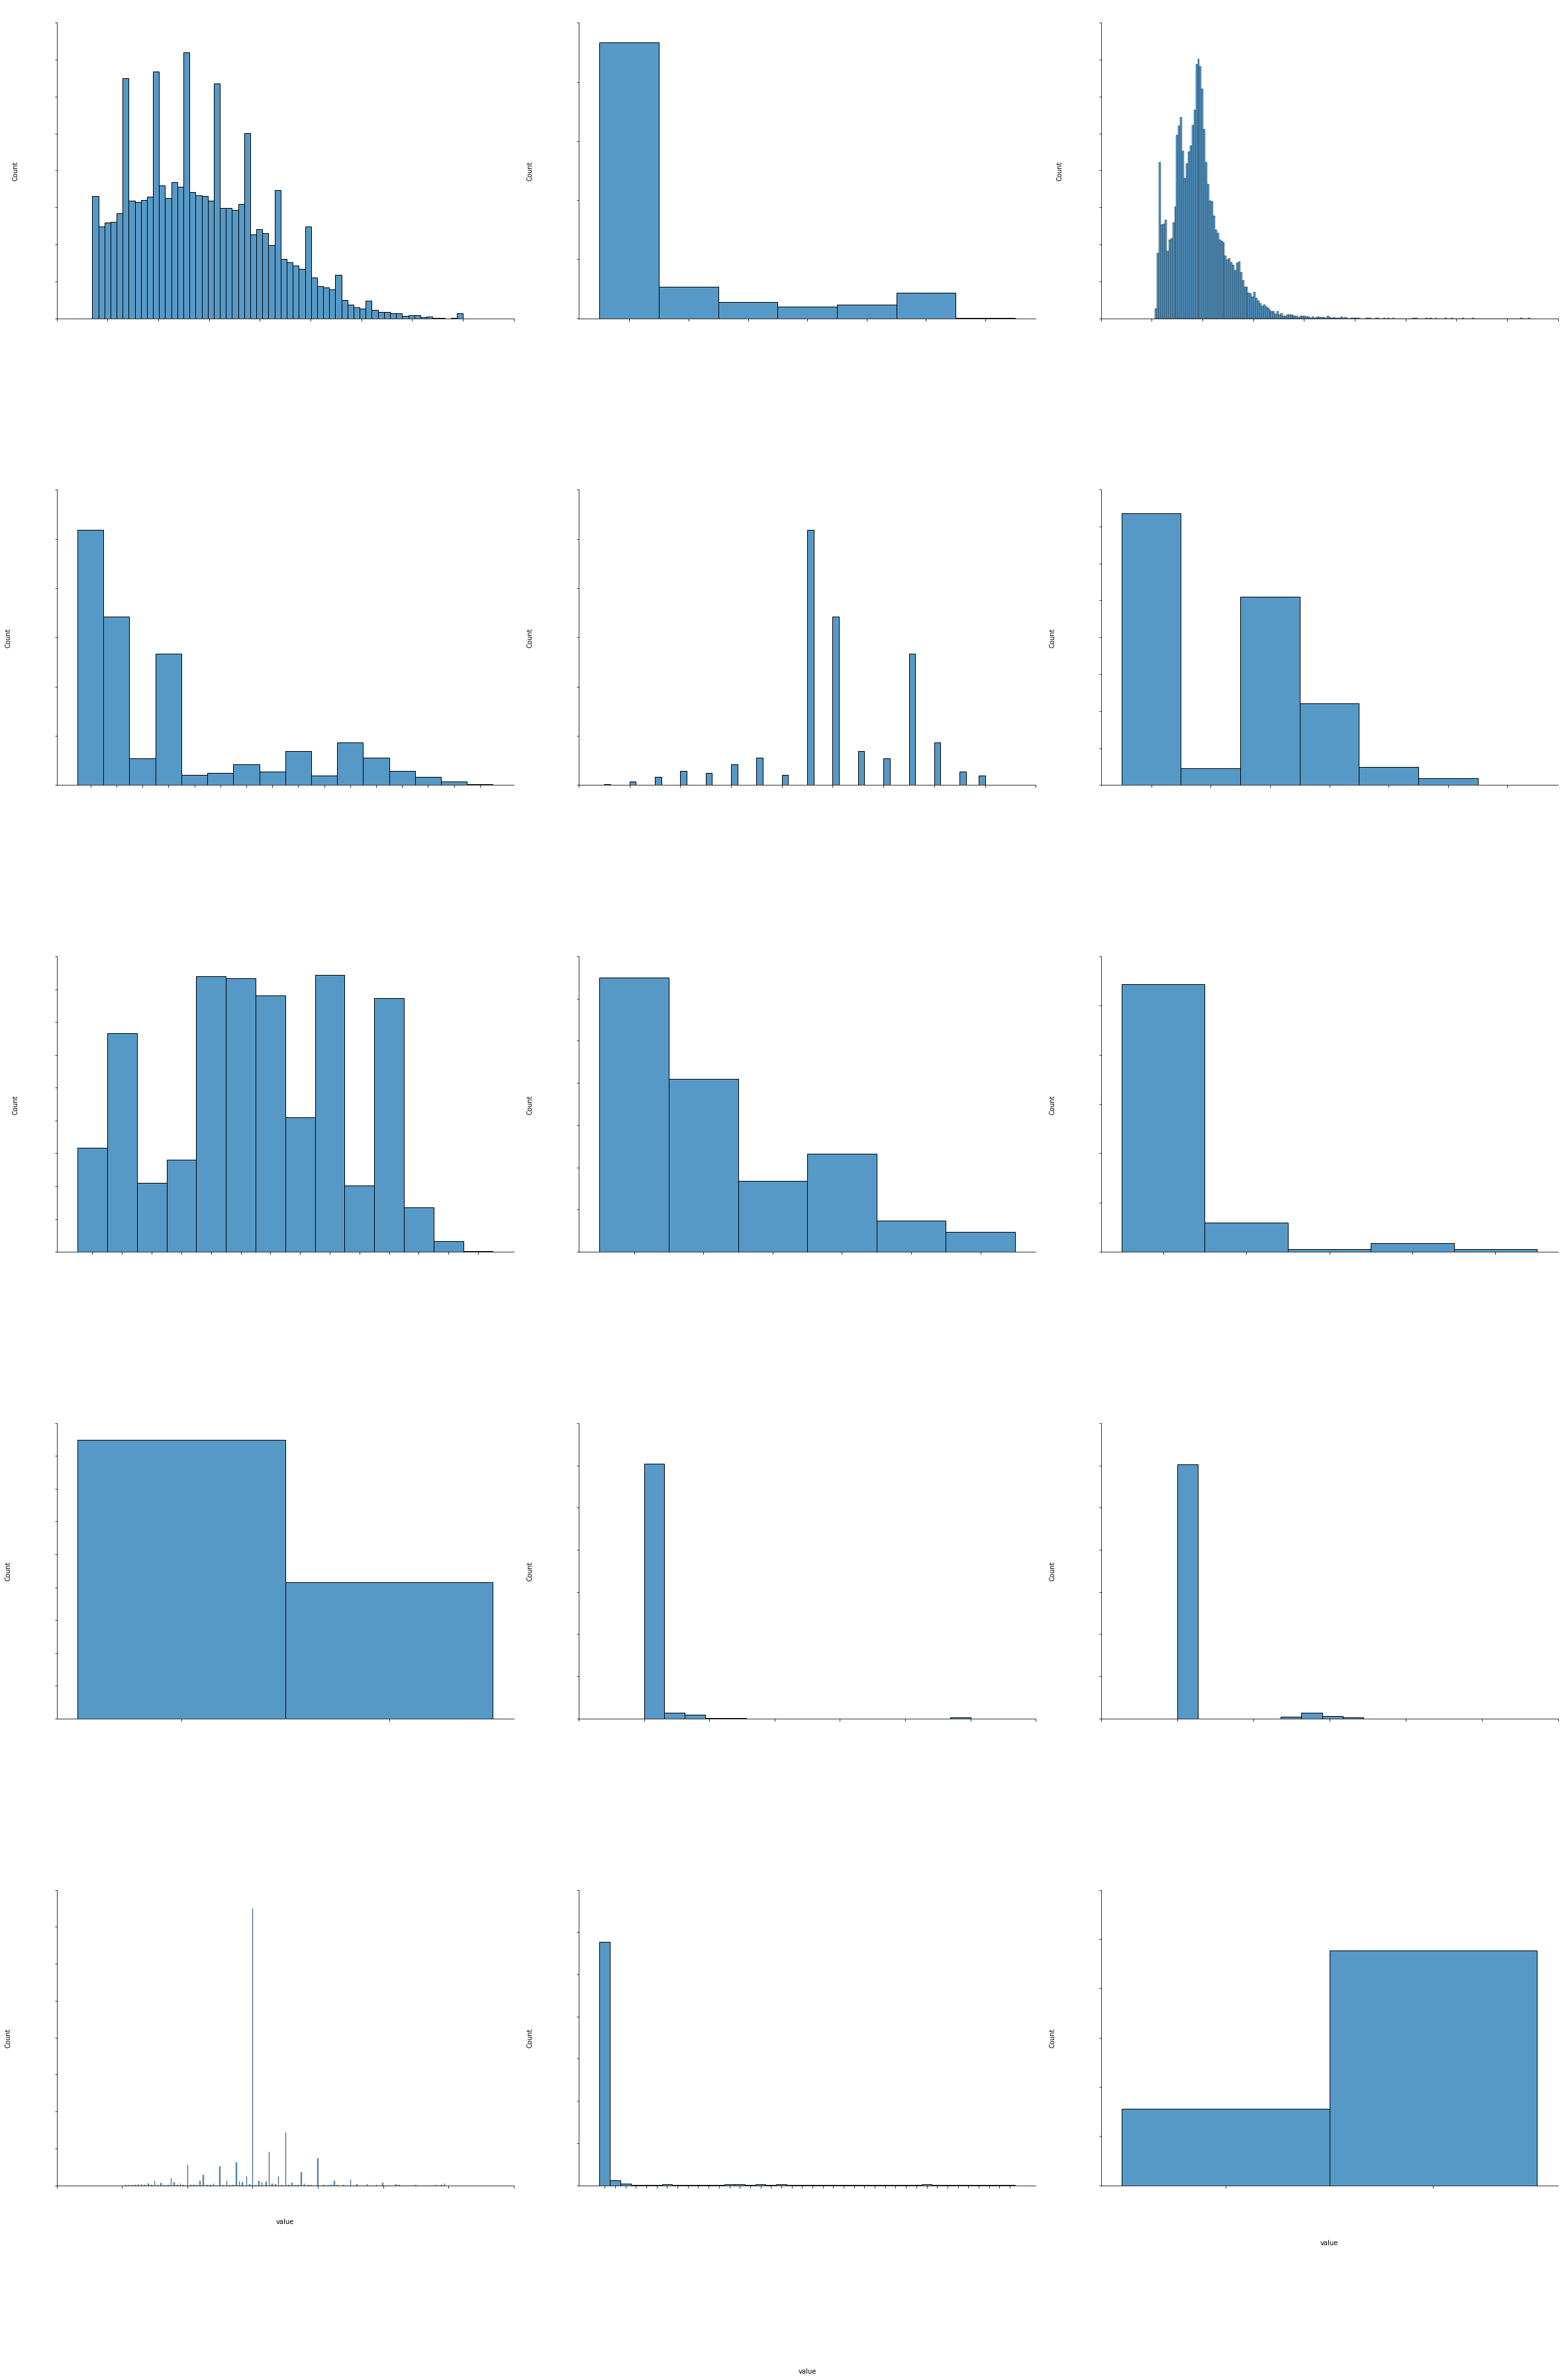

In [7]:
values = pd.melt(train, value_vars = train.columns.to_list())

g = sns.FacetGrid(values, col='variable', col_wrap=3, height=10, aspect=1.1, sharex=False, sharey=False)
g.map(sns.histplot, 'value')
g.set_xticklabels(rotation=90, size=18, color='white')
g.set_yticklabels(size=18, color='white')
g.set_titles(size=28, color='white')
g.figure.tight_layout()




## PREPROCESING

### AGE

I group the age distribution in 15 bins, Then I apply this grouped criteria to the respective column. In this way, I also categorize each age interval with a kind of label encoder

In [6]:
hist, div = np.histogram(train['age'], bins = 15)
div = np.around(div)
div[-1] = 91

train['age'] = np.digitize(train['age'], bins=div)

In [7]:
ages = []
for i in range(len(div) - 1):
    a = div[i]
    b = div[i + 1] - 1
    ages.append('['+str(a)+' , '+str(b)+']')
ages[-1] = '[85.0 , 91.0]'
age_pair = zip(list(range(1,16)), ages)
age_pair =  dict(age_pair)

### EDUCATION
 I analyze the education feature. I see the histogram distribution

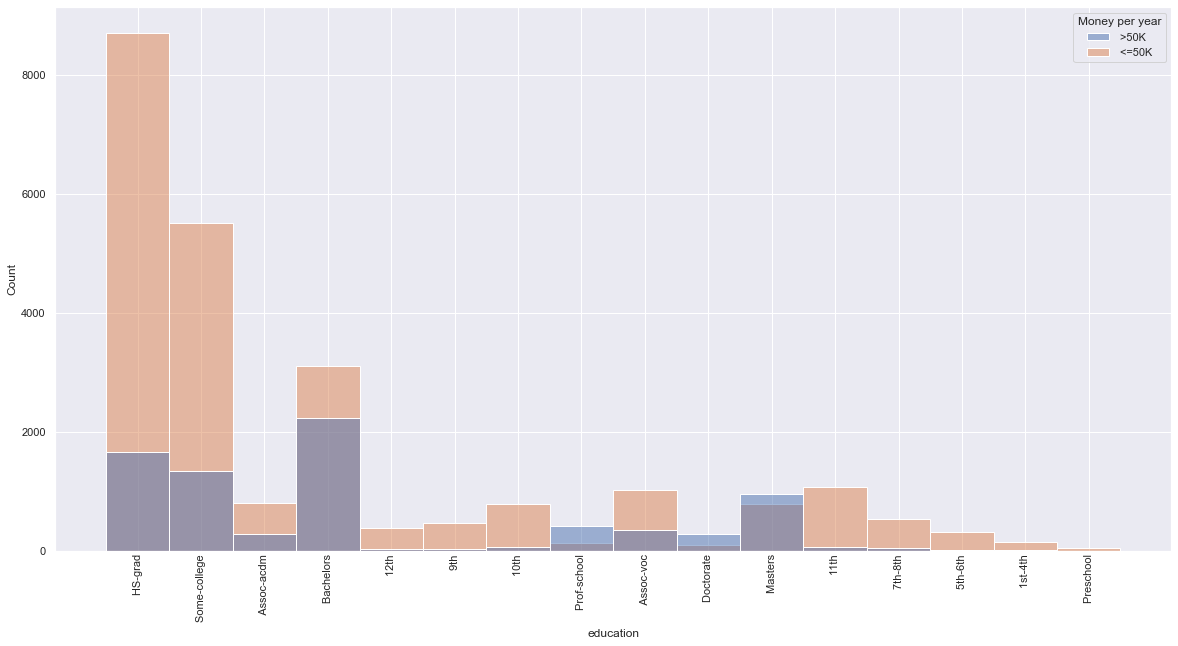

In [11]:
def graph_hist_ratio(val):
    sns.set(rc={"figure.figsize":(20, 10), "xtick.direction":'in'})
    g = sns.histplot(train, x=val, hue='Money per year', multiple='layer')
    plt.xticks(rotation=90)

graph_hist_ratio('education')

I group that class with a similar proportion of money per year:
    

In [12]:
def ratio_values(val):
    mpy= train[[val, 'Money per year']]
    more_50k = mpy[mpy['Money per year'] == ' >50K']
    less_50k =  mpy[mpy['Money per year'] == ' <=50K']
    less = less_50k.groupby(val).count()
    more = more_50k.groupby(val).count()
    ratio = more/less #rate between money per year great than 50K and less than 50K
    ratio['index'] = list(range(len(ratio)))
    return ratio.sort_values(by='Money per year')

a = ratio_values('education').index
a = np.array(a)


In [13]:
def educ_convert(value):
    index = a
    incom = index[[0,1,2,3,4,5,6,13]]
    asoc = index[[7,8]]
    maj = index[[10,14]]
    college = index[[11,15]]
    if value in incom:
        return 'Incomplete HS'
    elif value in asoc:
        return 'Assoc'
    elif value in maj:
        return 'Dr/Prof'
    elif value in college:
        return 'College/Hs grad'
    else:
        return value

train['education'] = train['education'].apply(educ_convert)


The 'education - num' features is the total education time in years. I can drop this, because is a redundant information

### MARITAL STATUS

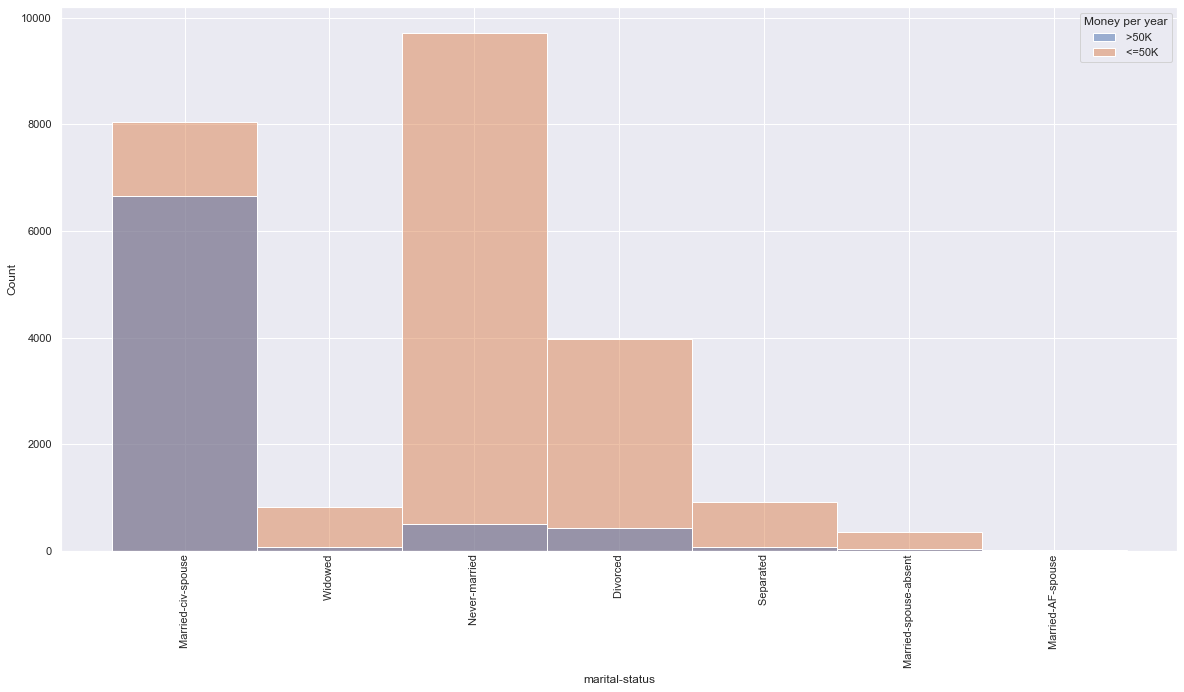

In [14]:
graph_hist_ratio('marital-status')

Separated and widowed has the same proportion. I assume that I can define just a unique value 'Separated/Widowed'

In [97]:
def status_convert(val):
    if val in [' Separated', ' Widowed']:
        return 'Separated/Widowed'
    else:
        return val

train['marital-status'] = train['marital-status'].apply(status_convert) 

### WORKCLASS

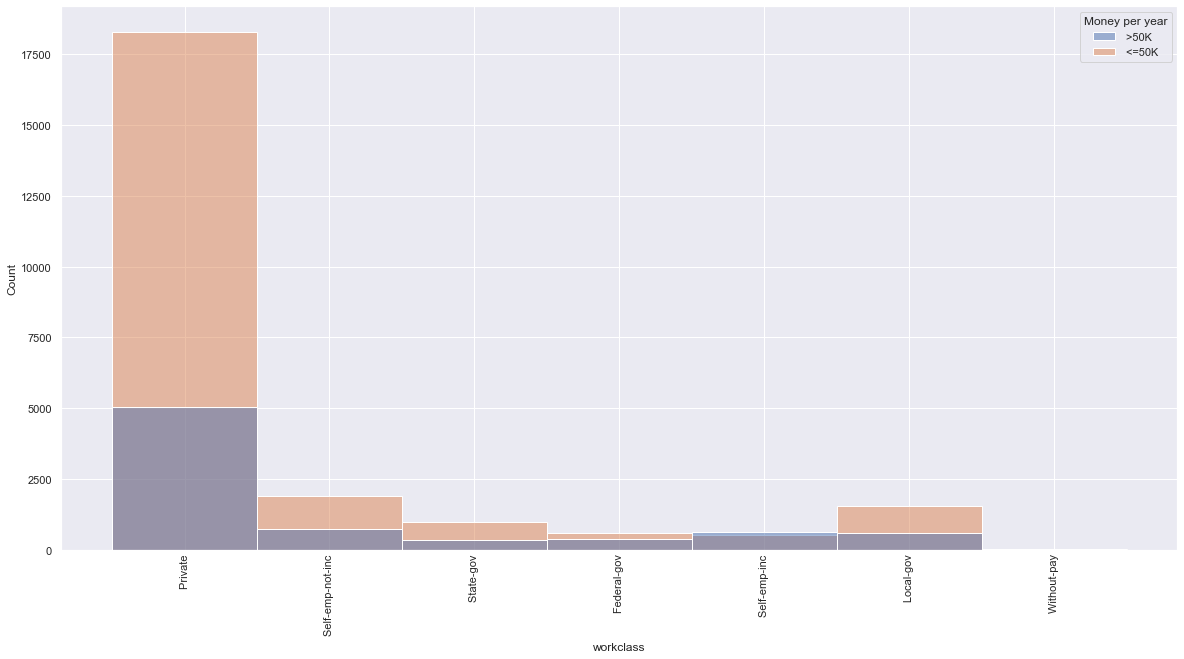

In [15]:
graph_hist_ratio('workclass')

In [99]:
def workclass_convert(val):
    if val in [' Never-worked', ' Without-pay']:
        return 'No incomes'
    elif val in [' Self-emp-not-inc', ' Local-gov']:
        return 'Not-inc/Local-gov'
    else:
        return val

train['workclass'] = train['workclass'].apply(workclass_convert) 
# point biserial correlation 
#  Chi-square estimate 

### OCCUPATION

In [100]:

# graph_hist_ratio('occupation')

In [101]:
# ratio_values('occupation')

In [102]:
def occupation_convert(val):
    if val in [' Other-service', ' Handlers-cleaners']:
        return 'Handlers and other services'
    elif val in [' Machine-op-inspct', ' Adm-clerical', ' Farming-fishing']:
        return 'Farming, clerical, op machine'
    else:
        return val
train['occupation'] = train['occupation'].apply(occupation_convert) 

### RELATIONSHIP

In [103]:
# graph_hist_ratio('relationship')

It's seem there is nothing to do here.

### RACE

In [104]:
# graph_hist_ratio('race')
# ratio_values('race')

In [105]:
def race_convert(val):
    if val in [' Amer-Indian-Eskimo', ' Black', ' Other']:
        return 'Minorities'
    else:
        return val
train['race'] = train['race'].apply(race_convert) 

### CAPITAL LOSS & CAPITAL GAIN

In [106]:
# graph_hist_ratio('capital-loss')
# graph_hist_ratio('capital-gain')


Since the histogram show a practically a unique value, I suppouse That these features can be droped. Previously, I check the histogram in a lower range, but the result is the same

In [107]:
da = train[train['capital-gain']<500]
#sns.histplot(da, x ='capital-gain')

In [108]:
del train['capital-gain']
del train['capital-loss']

## CORRELATION
Now, I analyze correlation between variables. 